In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  3 of 3 completed


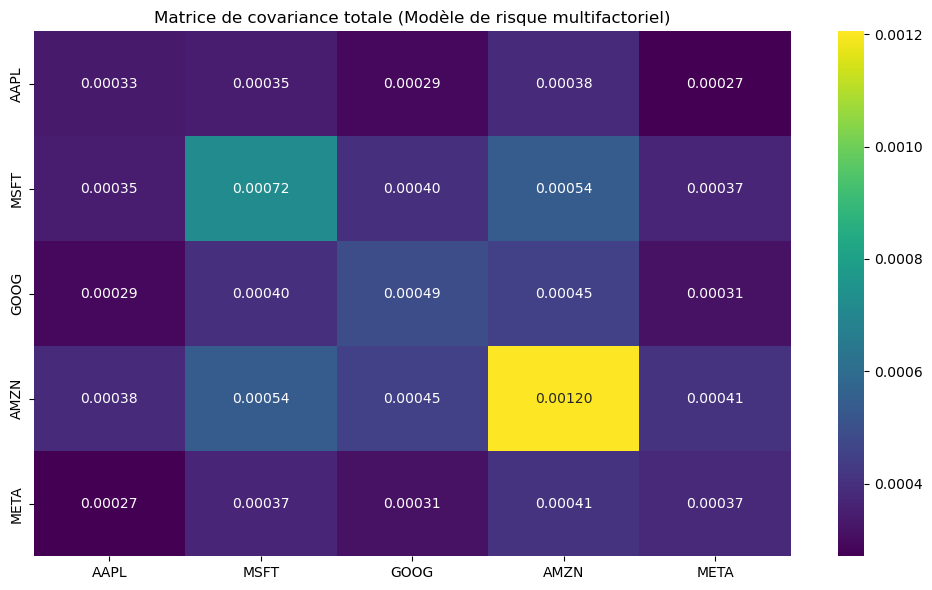

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_73268/37047371.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  portfolio_variance = float(w.T @ Sigma_total @ w)


Volatilité quotidienne du portefeuille équipondéré : 2.06353%

Résumé du modèle de risque :

  Ticker  Alpha (intercept)        R2  Beta ^GSPC  Beta ^IXIC  Beta ^RUT
0   AAPL           0.000138  0.773853    0.687796    0.786339  -0.386634
1   MSFT           0.000242  0.778179    0.506822    1.203036  -0.703054
2   GOOG          -0.000017  0.691275   -0.026054    1.557894  -0.543926
3   AMZN          -0.000103  0.669054   -0.537677    2.005026  -0.354187
4   META           0.000264  0.502324   -1.110204    2.591061  -0.386349


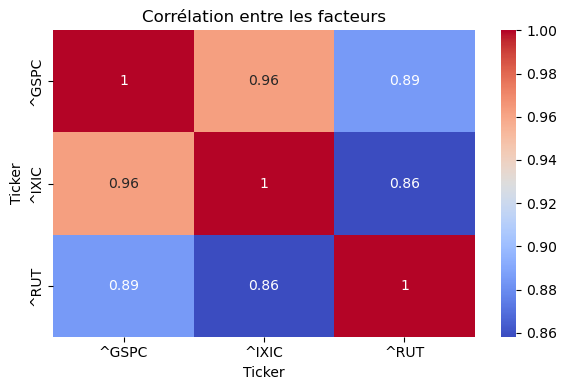

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_73268/37047371.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  marginal = float(w.T @ B[:, i].reshape(-1, 1) * Sigma_f[i, i] * B[:, i].reshape(1, -1) @ w)
/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_73268/37047371.py:105: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f" - {factor}: {100 * marginal / float(portfolio_total_risk):.2f}%")
/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_73268/37047371.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single ele


Contribution du risque total :
 - Systématique (facteurs) : 63.25%
 - Spécifique (idiosyncratique) : 36.75%

Attribution du risque du portefeuille :
 - ^GSPC: 0.33%
 - ^IXIC: 164.99%
 - ^RUT: 12.55%
 - Résiduel (idiosyncratique) : 10.78%


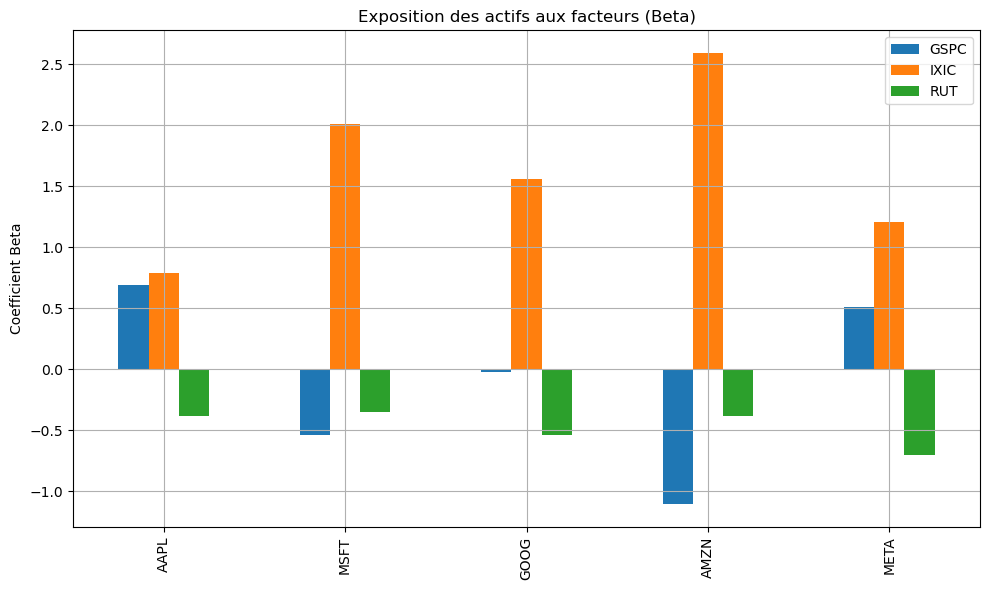

In [12]:
import yfinance as yf

# Téléchargement des données
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']
factor_proxies = ['^GSPC', '^IXIC', '^RUT']
start_date = '2022-01-01'
end_date = '2023-12-31'

# Télécharger les données
data_assets = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
data_factors = yf.download(factor_proxies, start=start_date, end=end_date, auto_adjust=True)

# Extraire les prix de clôture ajustés
if 'Close' in data_assets:
    prices_assets = data_assets['Close']
else:
    prices_assets = data_assets

if 'Close' in data_factors:
    prices_factors = data_factors['Close']
else:
    prices_factors = data_factors


# Calcul des rendements log
returns_assets = np.log(prices_assets / prices_assets.shift(1)).dropna()
returns_factors = np.log(prices_factors / prices_factors.shift(1)).dropna()
returns_assets = returns_assets.loc[returns_factors.index]

# Étape 2 : Régression multifactorielle
results = {}
residuals = pd.DataFrame(index=returns_assets.index)
betas = []

for asset in returns_assets.columns:
    y = returns_assets[asset]
    X = returns_factors
    reg = LinearRegression().fit(X, y)
    pred = reg.predict(X)
    residuals[asset] = y - pred
    results[asset] = {
        'intercept': reg.intercept_,
        'betas': reg.coef_,
        'r2': reg.score(X, y)
    }
    betas.append(reg.coef_)

B = np.array(betas)  # Matrice B (n_assets x n_factors)

# Étape 3 : Matrice de covariance des facteurs et des résidus
Sigma_f = returns_factors.cov().values
D = np.diag(residuals.var().values)
Sigma_total = B @ Sigma_f @ B.T + D

# Étape 4 : Visualisation de la matrice de covariance
plt.figure(figsize=(10, 6))
sns.heatmap(Sigma_total, xticklabels=tickers, yticklabels=tickers, annot=True, fmt=".5f", cmap="viridis")
plt.title("Matrice de covariance totale (Modèle de risque multifactoriel)")
plt.tight_layout()
plt.show()

# Étape 5 : Attribution du risque pour un portefeuille équipondéré
w = np.array([1/len(tickers)] * len(tickers)).reshape(-1, 1)
portfolio_variance = float(w.T @ Sigma_total @ w)
portfolio_volatility = np.sqrt(portfolio_variance)
print(f"Volatilité quotidienne du portefeuille équipondéré : {portfolio_volatility:.5%}")

# Résumé des résultats
summary = pd.DataFrame({
    'Ticker': tickers,
    'Alpha (intercept)': [results[t]['intercept'] for t in tickers],
    'R2': [results[t]['r2'] for t in tickers]
})
for i, factor in enumerate(factor_proxies):
    summary[f'Beta {factor}'] = [results[t]['betas'][i] for t in tickers]

print("\nRésumé du modèle de risque :\n")
print(summary)

# Matrice de corrélation des facteurs
plt.figure(figsize=(6, 4))
sns.heatmap(returns_factors.corr(), annot=True, cmap="coolwarm")
plt.title("Corrélation entre les facteurs")
plt.tight_layout()
plt.show()

# Pourcentage du risque total expliqué par les facteurs vs spécifique
total_risk = np.trace(Sigma_total)
systematic_risk = np.trace(B @ Sigma_f @ B.T)
specific_risk = np.trace(D)

print(f"\nContribution du risque total :")
print(f" - Systématique (facteurs) : {100 * systematic_risk / total_risk:.2f}%")
print(f" - Spécifique (idiosyncratique) : {100 * specific_risk / total_risk:.2f}%")

# Contribution de chaque facteur au risque du portefeuille
factor_contributions = (B @ Sigma_f) @ B.T
portfolio_factor_risk = w.T @ factor_contributions @ w
portfolio_specific_risk = w.T @ D @ w
portfolio_total_risk = w.T @ Sigma_total @ w

print("\nAttribution du risque du portefeuille :")
for i, factor in enumerate(factor_proxies):
    marginal = float(w.T @ B[:, i].reshape(-1, 1) * Sigma_f[i, i] * B[:, i].reshape(1, -1) @ w)
    print(f" - {factor}: {100 * marginal / float(portfolio_total_risk):.2f}%")


print(f" - Résiduel (idiosyncratique) : {100 * float(portfolio_specific_risk) / float(portfolio_total_risk):.2f}%")


# Visualisation des betas
beta_df = pd.DataFrame(B, columns=[f.replace('^', '') for f in factor_proxies], index=tickers)
beta_df.plot(kind="bar", figsize=(10, 6))
plt.title("Exposition des actifs aux facteurs (Beta)")
plt.ylabel("Coefficient Beta")
plt.grid(True)
plt.tight_layout()
plt.show()


Initializing Market Making Simulation with Delta Hedging
Simulation Parameters:
  Initial Price: $100.00
  Strike Price: $105.00
  Drift: 5.0%
  Volatility: 25.0%
  Time Horizon: 0.25
  Time Step: 0.003968253968253968
  Option Maturity: 0.25
  Option Type: call
  Order Probability: 8.0%
  Seed: 42

Market Maker Parameters:
  Starting Cash: $50000.00
  Gamma: 0.1
  Risk Free Rate: 0.05
  Base Spread: $0.30
  Min Spread: $0.05
  Max Spread: $1.50

Starting Market Making Simulation with Delta Hedging
Generated price path: 64 time steps
Initial price: $100.00, Final price: $84.42
Initial portfolio value: $50000.00
Simulation parameters:
  Initial underlying: $100.00
  Strike price: $105.00
  Option maturity: 0.2500 years
  Volatility: 25.0%
  Order probability: 8.0%

Progress: 9.5% - Trades: 0, Hedges: 0, P&L: $0.00
Progress: 19.0% - Trades: 0, Hedges: 0, P&L: $0.00
Progress: 28.6% - Trades: 1, Hedges: 1, P&L: $-0.62
Progress: 38.1% - Trades: 2, Hedges: 2, P&L: $0.28
Progress: 47.6% - Trad

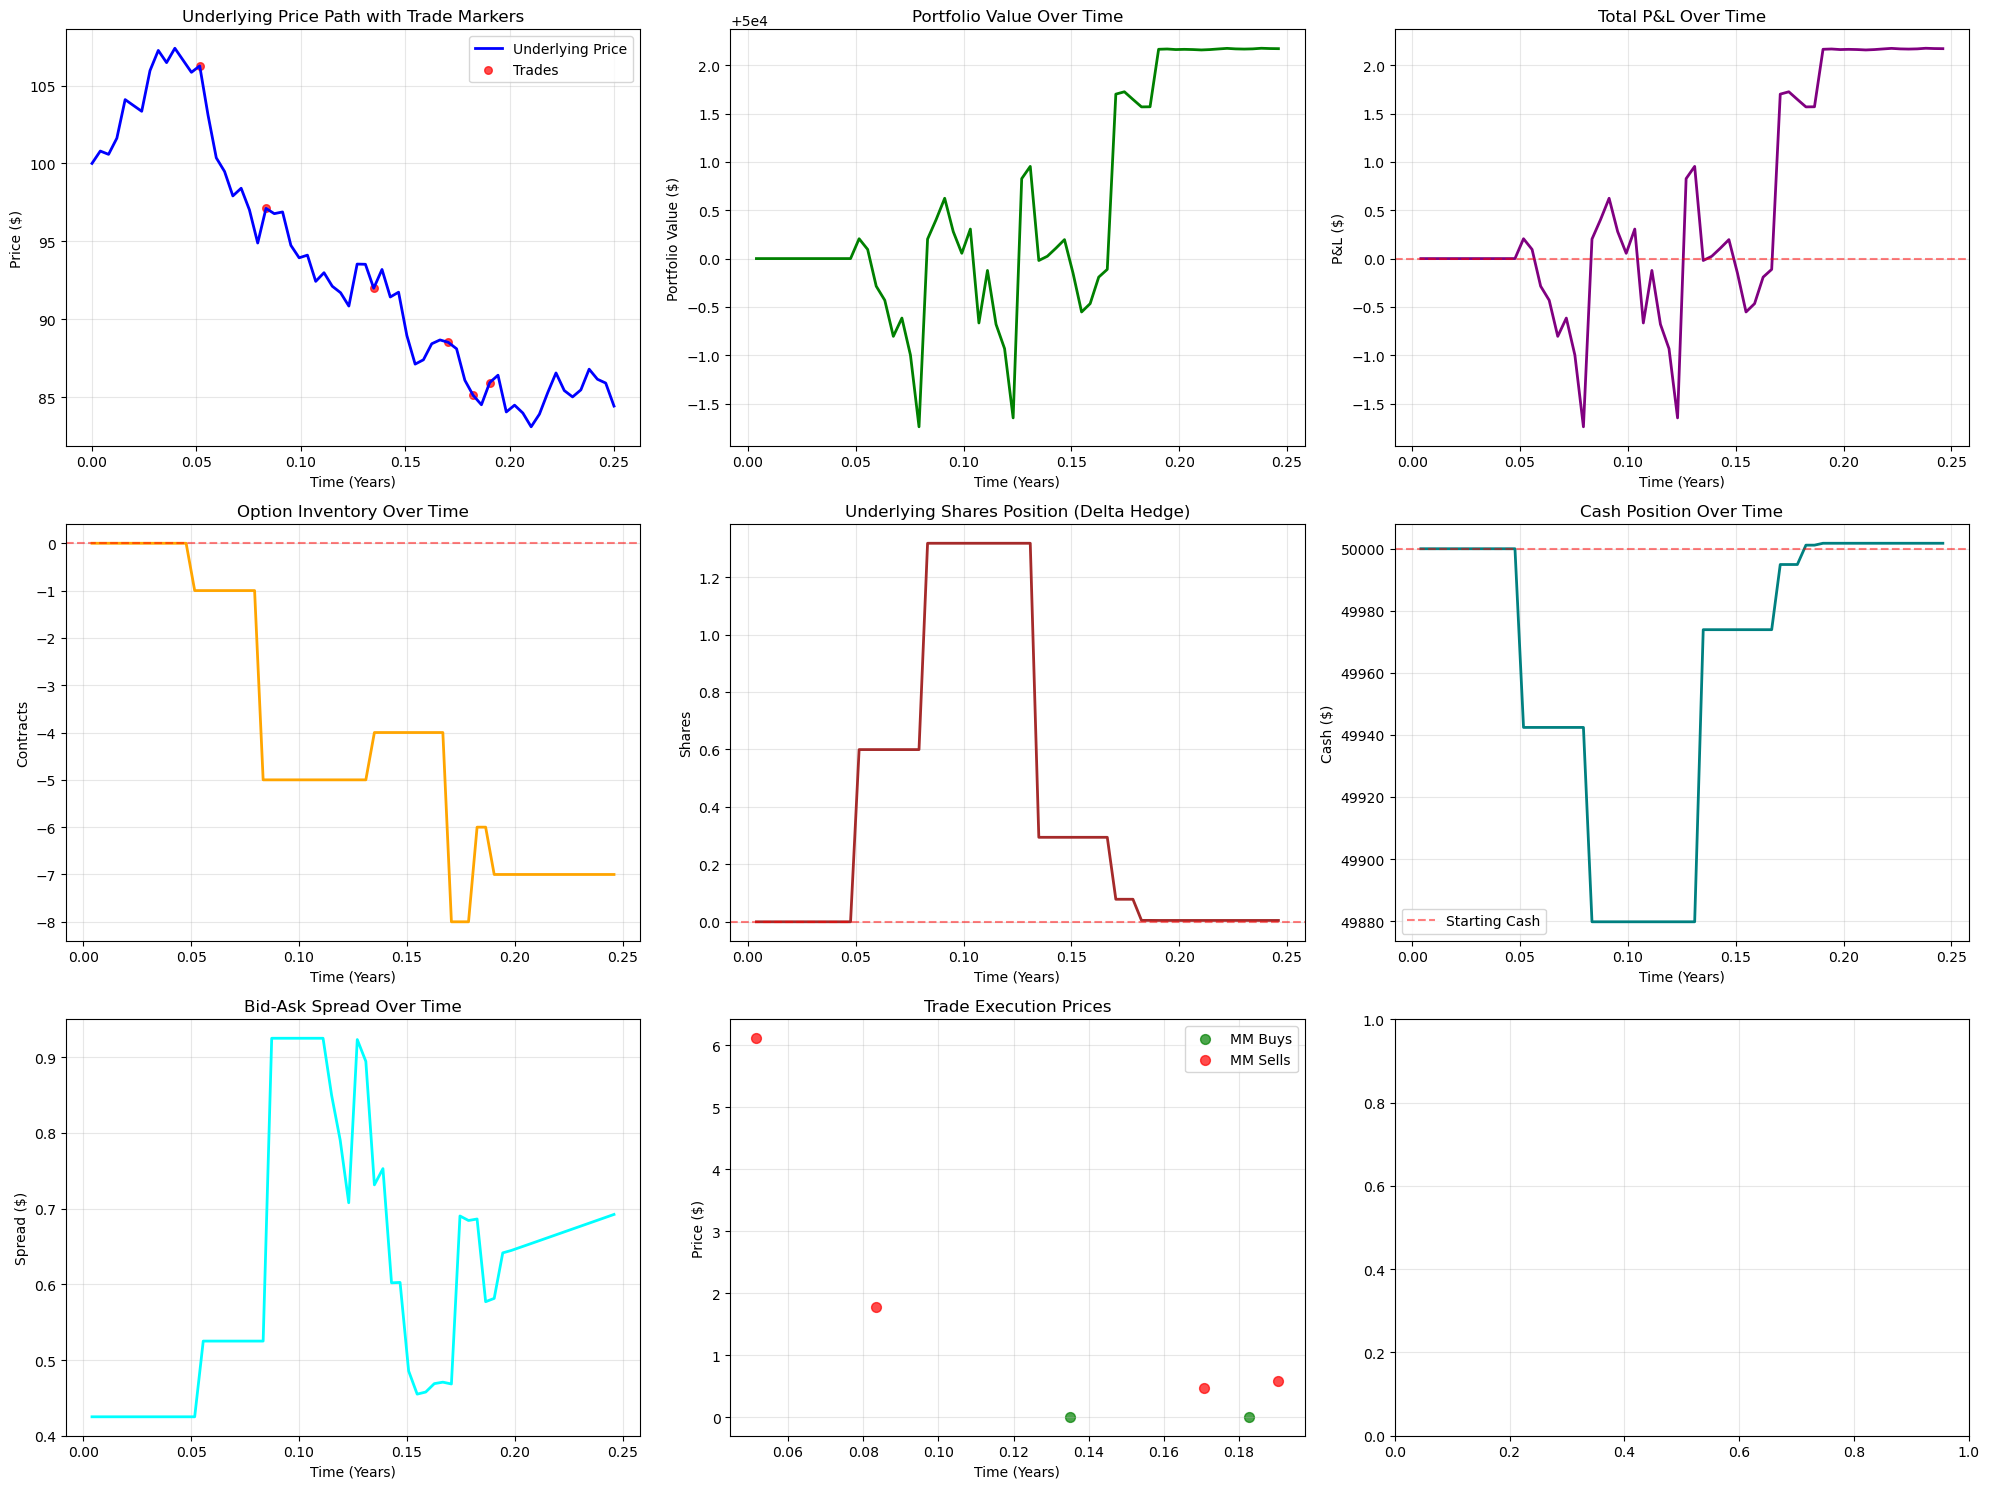

In [1]:
from main_simulator import run_market_making_simulation
simulation, results = run_market_making_simulation()

Comprehensive Market Making Strategy Backtest
Starting Market Making Backtest
Number of runs: 1000
Parameter variation: True
Parameter noise level: 15.0%
Base simulation parameters:
  initial_price: $100.00
  strike_price: $105.00
  volatility: 25.0%
  time_horizon: 0.25
  order_probability: 8.0%
  base_vol: 25.0%
  smile_curvature: 0.1

Starting 1000 simulation runs...

Starting Market Making Simulation with Delta Hedging
Generated price path: 64 time steps
Initial price: $100.00, Final price: $98.38
Initial portfolio value: $50000.00
Simulation parameters:
  Initial underlying: $100.00
  Strike price: $105.00
  Option maturity: 0.2500 years
  Volatility: 31.5%
  Order probability: 7.8%

Progress: 9.5% - Trades: 1, Hedges: 1, P&L: $0.45
Progress: 19.0% - Trades: 1, Hedges: 1, P&L: $0.82
Progress: 28.6% - Trades: 1, Hedges: 1, P&L: $1.07
Progress: 38.1% - Trades: 2, Hedges: 2, P&L: $2.47
Progress: 47.6% - Trades: 2, Hedges: 2, P&L: $2.89
Progress: 57.1% - Trades: 3, Hedges: 3, P&L: $5.

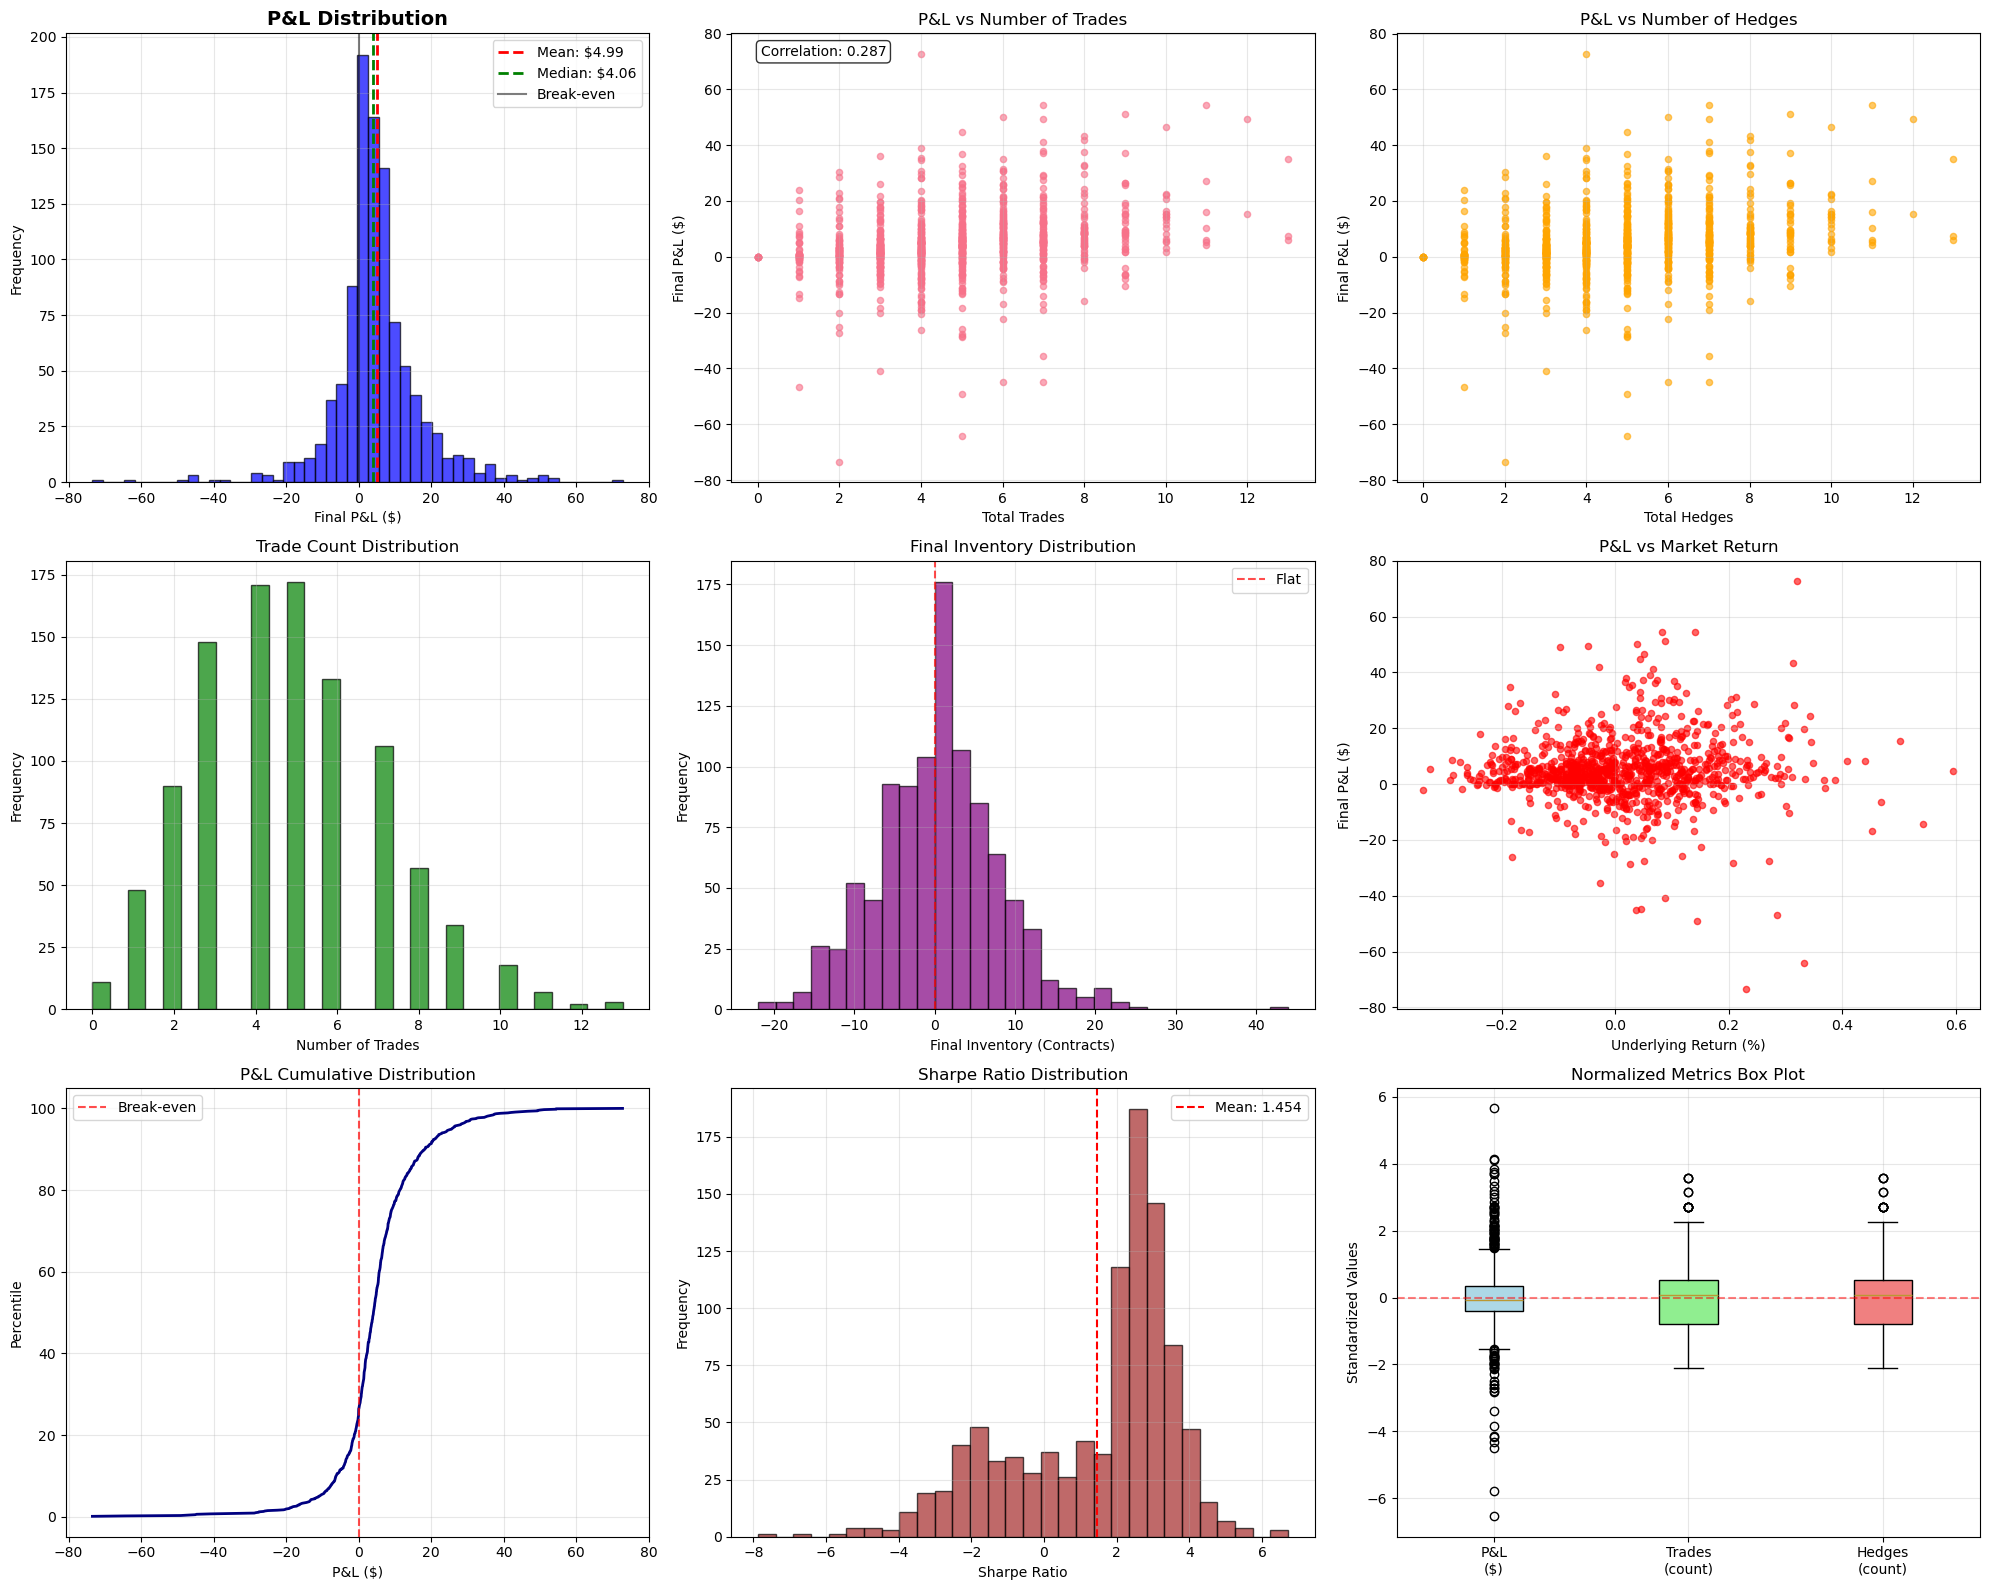

Results exported to backtest_results_1000runs_20250903_120339.csv
Exported 1000 simulation results with 17 metrics


In [2]:
from backtester import run_comprehensive_backtest
backtester = run_comprehensive_backtest(n_runs=1000)

NameError: name 'MarketMakingSimulation' is not defined